In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (144)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (148)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (76)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (7)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (192)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (106)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (327)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (56)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (416)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (329)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (396)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (417)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (30)_iaip.jpg
/kaggle/input/diseasecotton/data/val/fresh cotton leaf/d (351)_iaip.j

In [2]:
import glob
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
import os
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter
import cv2
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, merge, UpSampling2D, Cropping2D, ZeroPadding2D, Reshape, core, Convolution2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import optimizers
from keras import backend as K
from keras.optimizers import SGD
from keras.layers.merge import concatenate
from sklearn.metrics import fbeta_score

In [4]:
glob.glob('/kaggle/input/diseasecotton/data/train/*')

['/kaggle/input/diseasecotton/data/train/fresh cotton leaf',
 '/kaggle/input/diseasecotton/data/train/diseased cotton leaf',
 '/kaggle/input/diseasecotton/data/train/fresh cotton plant',
 '/kaggle/input/diseasecotton/data/train/diseased cotton plant']

In [5]:
TrainImage="/kaggle/input/diseasecotton/data/train"
TestImage="/kaggle/input/diseasecotton/data/val"
diseased_cotton_leaf_images = os.listdir(TrainImage + "/diseased cotton leaf")
diseased_cotton_plant_images = os.listdir(TrainImage + "/diseased cotton plant")
fresh_cotton_plant_images = os.listdir(TrainImage + "/fresh cotton plant")
fresh_cotton_leaf_images = os.listdir(TrainImage + "/fresh cotton leaf")

In [6]:
print(len(diseased_cotton_leaf_images), len(diseased_cotton_plant_images), len(fresh_cotton_plant_images), len(fresh_cotton_leaf_images))
NUM_TRAINING_IMAGES = len(diseased_cotton_leaf_images)+len(diseased_cotton_plant_images)+len(fresh_cotton_plant_images)+len(fresh_cotton_leaf_images)
print(NUM_TRAINING_IMAGES)

288 815 421 427
1951


In [7]:
image_size = 224 
BATCH_SIZE = 16 
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

data_path = '/kaggle/input/diseasecotton'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/data/train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory(data_path + '/data/val',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [8]:
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)

train batch  (16, 224, 224, 3)
test batch  (16, 224, 224, 3)


In [9]:
training_set.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [10]:
labels = ["diseased cotton leaf","diseased cotton plant","fresh cotton leaf","fresh cotton plant"]

In [11]:
sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

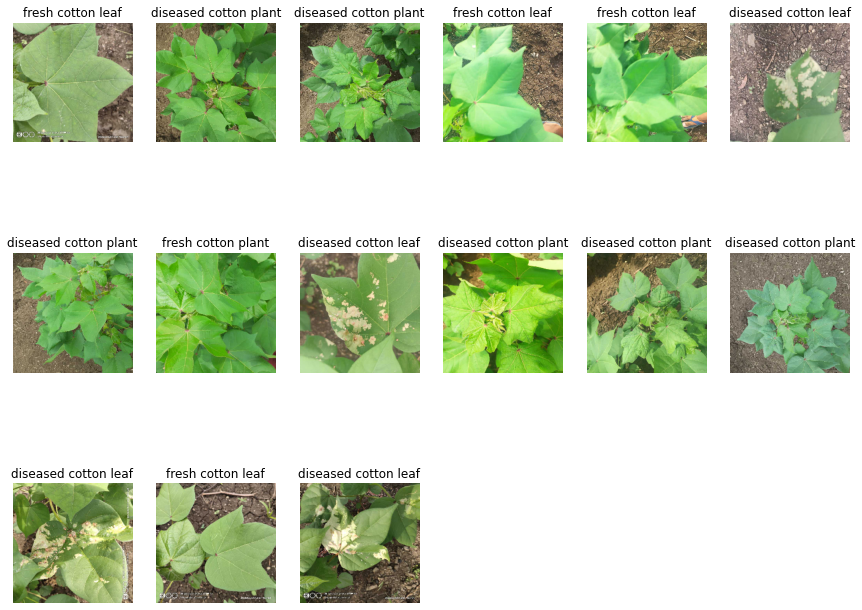

In [12]:
plt.figure(figsize=(15,12))
for i in range(15):
    plt.subplot(3, 6, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [13]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(15,15), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [14]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [15]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [16]:
#label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [17]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 50 kB 2.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [18]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=15, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [19]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 2.829861111111111, 1: 1.0, 2: 1.9086651053864168, 3: 1.9358669833729216}

In [20]:
print(efn.EfficientNetB7(weights='imagenet').input_shape) 

268320768/268317848 [==============================] - 3s 0us/step
(None, 600, 600, 3)


In [21]:
# EXTRA In case you want to save the h5 file 
# please dont forget to change the model names.
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [22]:
from keras import Input
from keras.layers import Conv2D, MaxPooling2D, Embedding, Reshape, Concatenate, SeparableConv2D
import tensorflow as tf
from keras.layers.normalization import BatchNormalization

inputs = Input(shape=(224, 224, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Output layer
output = Dense(units=4, activation='softmax')(x)

# Creating model and compiling
model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer='RMSprop', loss=categorical_smooth_loss, metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [23]:
history = model.fit_generator(training_set,
                              validation_data=testing_set,
                              callbacks=[lr_reduce, es_callback],
                              epochs=20)

Epoch 1/20
122/122 [==============================] - 45s 368ms/step - loss: 1.2269 - accuracy: 0.4936 - val_loss: 1.3780 - val_accuracy: 0.3117
Epoch 2/20
122/122 [==============================] - 41s 336ms/step - loss: 0.9924 - accuracy: 0.6489 - val_loss: 1.3818 - val_accuracy: 0.2716
Epoch 3/20
122/122 [==============================] - 39s 324ms/step - loss: 0.9004 - accuracy: 0.7160 - val_loss: 1.4637 - val_accuracy: 0.1698
Epoch 4/20
122/122 [==============================] - 39s 319ms/step - loss: 0.7978 - accuracy: 0.7899 - val_loss: 1.5084 - val_accuracy: 0.2469
Epoch 5/20
122/122 [==============================] - 40s 332ms/step - loss: 0.7500 - accuracy: 0.8170 - val_loss: 1.2818 - val_accuracy: 0.4043
Epoch 6/20
122/122 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.8503
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
122/122 [==============================] - 39s 323ms/step - loss: 0.7048 - accuracy: 0.8503 - val_l

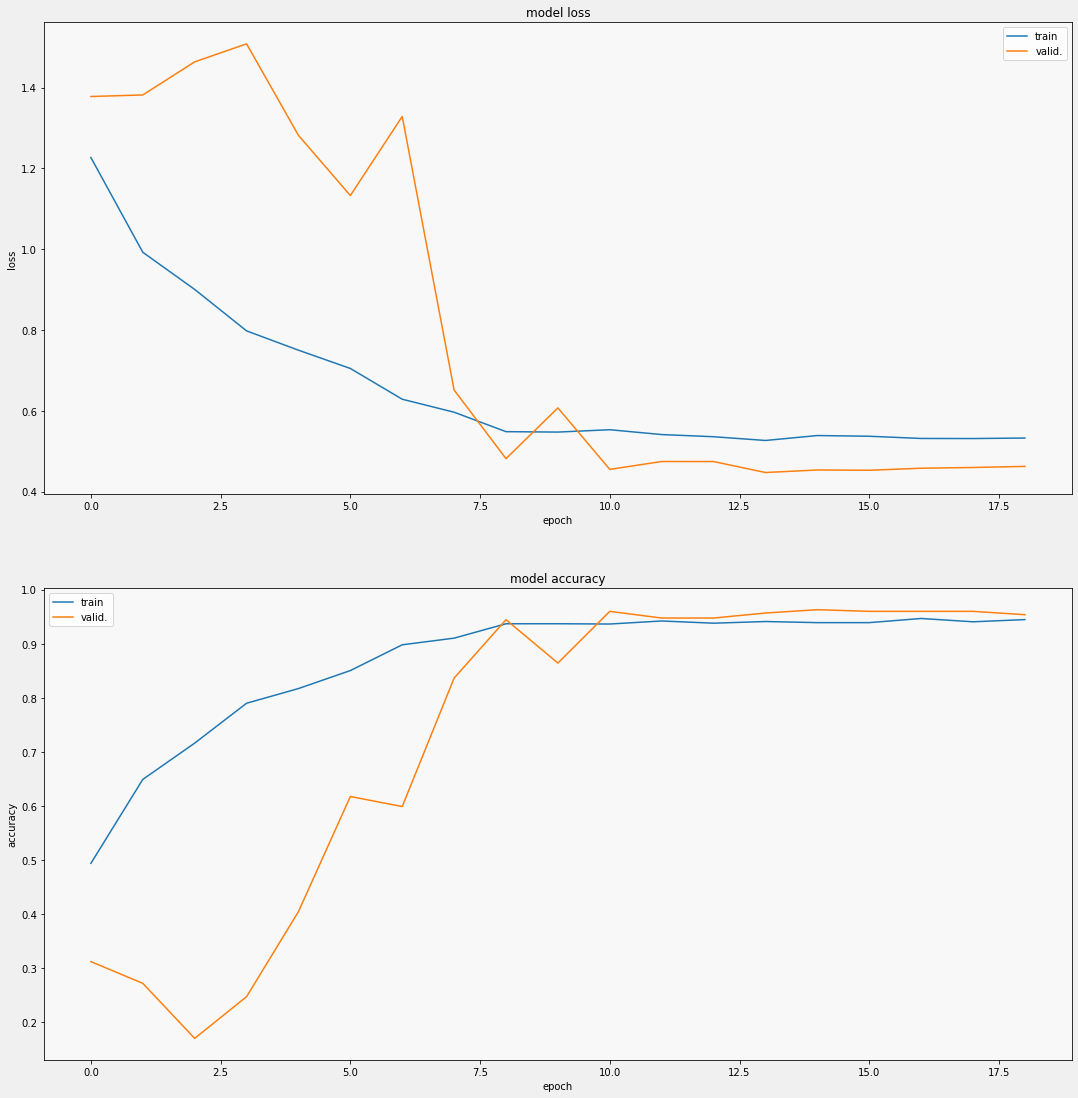

In [24]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [25]:
pretrained_efnet = efn.EfficientNetB7(input_shape=(image_size, image_size, 3), weights='noisy-student', include_top=False)

for layer in pretrained_efnet.layers:
  layer.trainable = False

x2 = pretrained_efnet.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
model_out = tf.keras.layers.Dense(4, activation='softmax', name="predictions_head")(x2)

model_efnet = Model(inputs=pretrained_efnet.input, outputs=model_out)
model_efnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
model_efnet.summary()

258072576/258068648 [==============================] - 3s 0us/step
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________

In [26]:
history_efnet = model_efnet.fit_generator(training_set,
                                          validation_data=testing_set,
                                          callbacks=[lr_reduce, es_callback],
                                          epochs=15)

Epoch 1/15
122/122 [==============================] - 46s 381ms/step - loss: 1.1288 - accuracy: 0.5469 - val_loss: 0.8870 - val_accuracy: 0.7068
Epoch 2/15
122/122 [==============================] - 42s 344ms/step - loss: 0.9912 - accuracy: 0.6325 - val_loss: 0.8008 - val_accuracy: 0.7593
Epoch 3/15
122/122 [==============================] - ETA: 0s - loss: 0.9507 - accuracy: 0.6709
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
122/122 [==============================] - 42s 345ms/step - loss: 0.9507 - accuracy: 0.6709 - val_loss: 0.7306 - val_accuracy: 0.8457
Epoch 4/15
122/122 [==============================] - 42s 342ms/step - loss: 0.8700 - accuracy: 0.7345 - val_loss: 0.7178 - val_accuracy: 0.8241
Epoch 5/15
122/122 [==============================] - ETA: 0s - loss: 0.8393 - accuracy: 0.7478
Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
122/122 [==============================] - 42s 344ms/step - loss: 0.8393 - acc

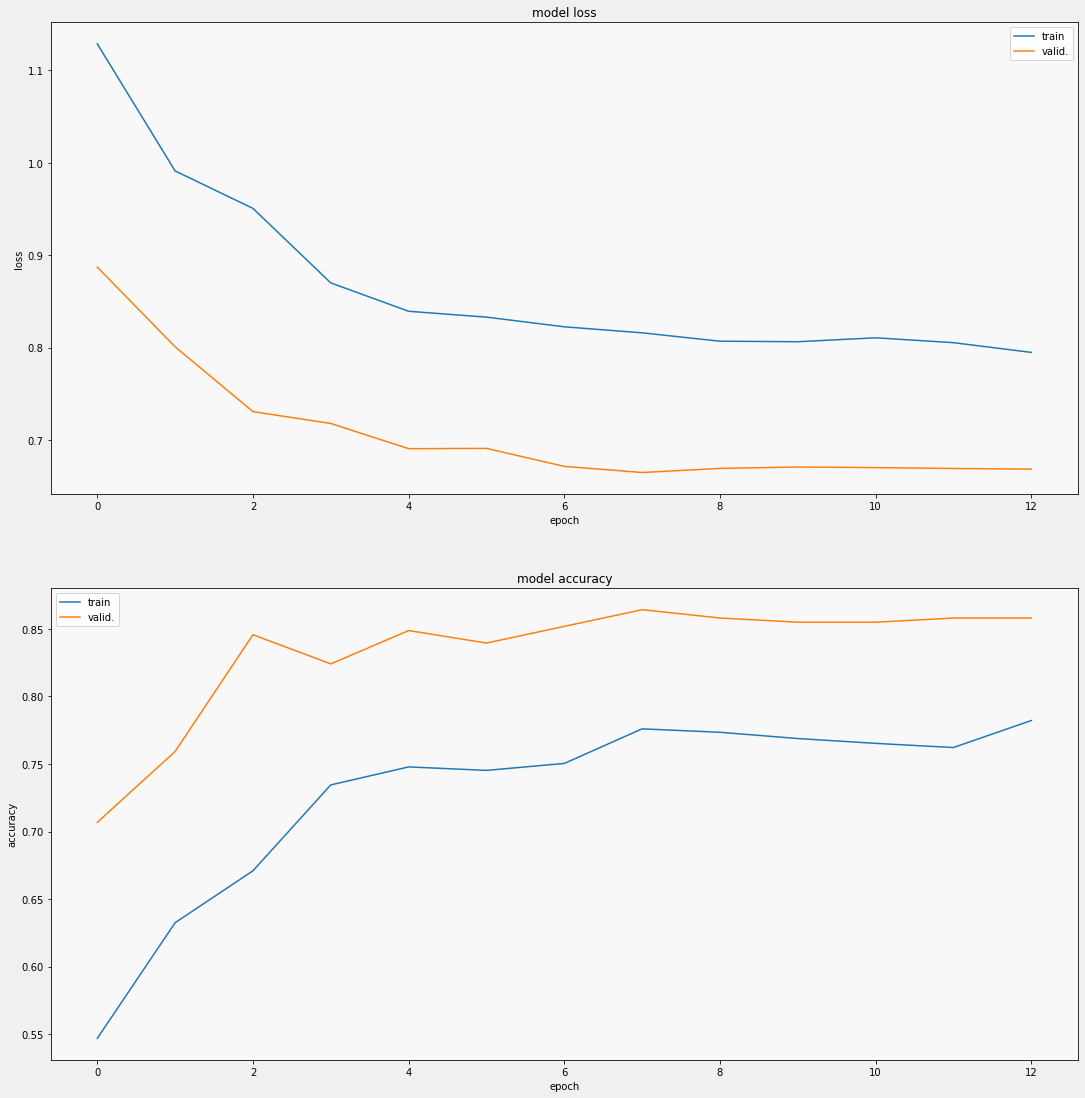

In [27]:
display_training_curves(history_efnet.history['loss'], history_efnet.history['val_loss'], 'loss', 211)
display_training_curves(history_efnet.history['accuracy'], history_efnet.history['val_accuracy'], 'accuracy', 212)

The EfficientNetB7 did not work well for us

In [28]:
#try
pretrained_densenet = tf.keras.applications.DenseNet121(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers[:-3]:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(4, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________

In [29]:
history_densenet = model_densenet.fit_generator(training_set,
                                                validation_data=testing_set,
                                                callbacks=[lr_reduce, es_callback],
                                                epochs=10)

Epoch 1/10
122/122 [==============================] - 38s 311ms/step - loss: 1.4609 - accuracy: 0.5659 - val_loss: 0.6862 - val_accuracy: 0.8426
Epoch 2/10
122/122 [==============================] - 36s 298ms/step - loss: 0.8997 - accuracy: 0.7237 - val_loss: 0.6225 - val_accuracy: 0.9012
Epoch 3/10
122/122 [==============================] - ETA: 0s - loss: 0.8540 - accuracy: 0.7371
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
122/122 [==============================] - 36s 296ms/step - loss: 0.8540 - accuracy: 0.7371 - val_loss: 0.5467 - val_accuracy: 0.9290
Epoch 4/10
122/122 [==============================] - 36s 296ms/step - loss: 0.7523 - accuracy: 0.7945 - val_loss: 0.5067 - val_accuracy: 0.9537
Epoch 5/10
122/122 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.8042
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
122/122 [==============================] - 36s 297ms/step - loss: 0.7353 - accu

In [30]:
#Best model

In [31]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(4, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________

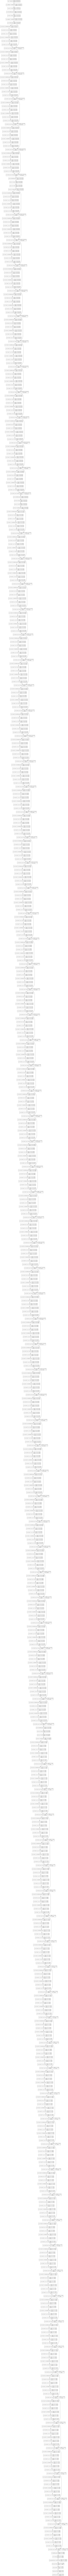

In [32]:
plot_model(model_densenet, show_shapes=True, to_file='model_densenet.png')

In [33]:
history_densenet = model_densenet.fit_generator(training_set,
                                                validation_data=testing_set,
                                                callbacks=[lr_reduce, es_callback],
                                                epochs=30)

Epoch 1/30
122/122 [==============================] - 42s 348ms/step - loss: 1.0410 - accuracy: 0.6233 - val_loss: 0.6638 - val_accuracy: 0.8951
Epoch 2/30
122/122 [==============================] - 38s 314ms/step - loss: 0.7069 - accuracy: 0.8283 - val_loss: 0.5615 - val_accuracy: 0.9290
Epoch 3/30
122/122 [==============================] - ETA: 0s - loss: 0.6424 - accuracy: 0.8842
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
122/122 [==============================] - 38s 311ms/step - loss: 0.6424 - accuracy: 0.8842 - val_loss: 0.5300 - val_accuracy: 0.9352
Epoch 4/30
122/122 [==============================] - 40s 326ms/step - loss: 0.6041 - accuracy: 0.9011 - val_loss: 0.5025 - val_accuracy: 0.9599
Epoch 5/30
122/122 [==============================] - ETA: 0s - loss: 0.5896 - accuracy: 0.9118
Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
122/122 [==============================] - 39s 322ms/step - loss: 0.5896 - acc

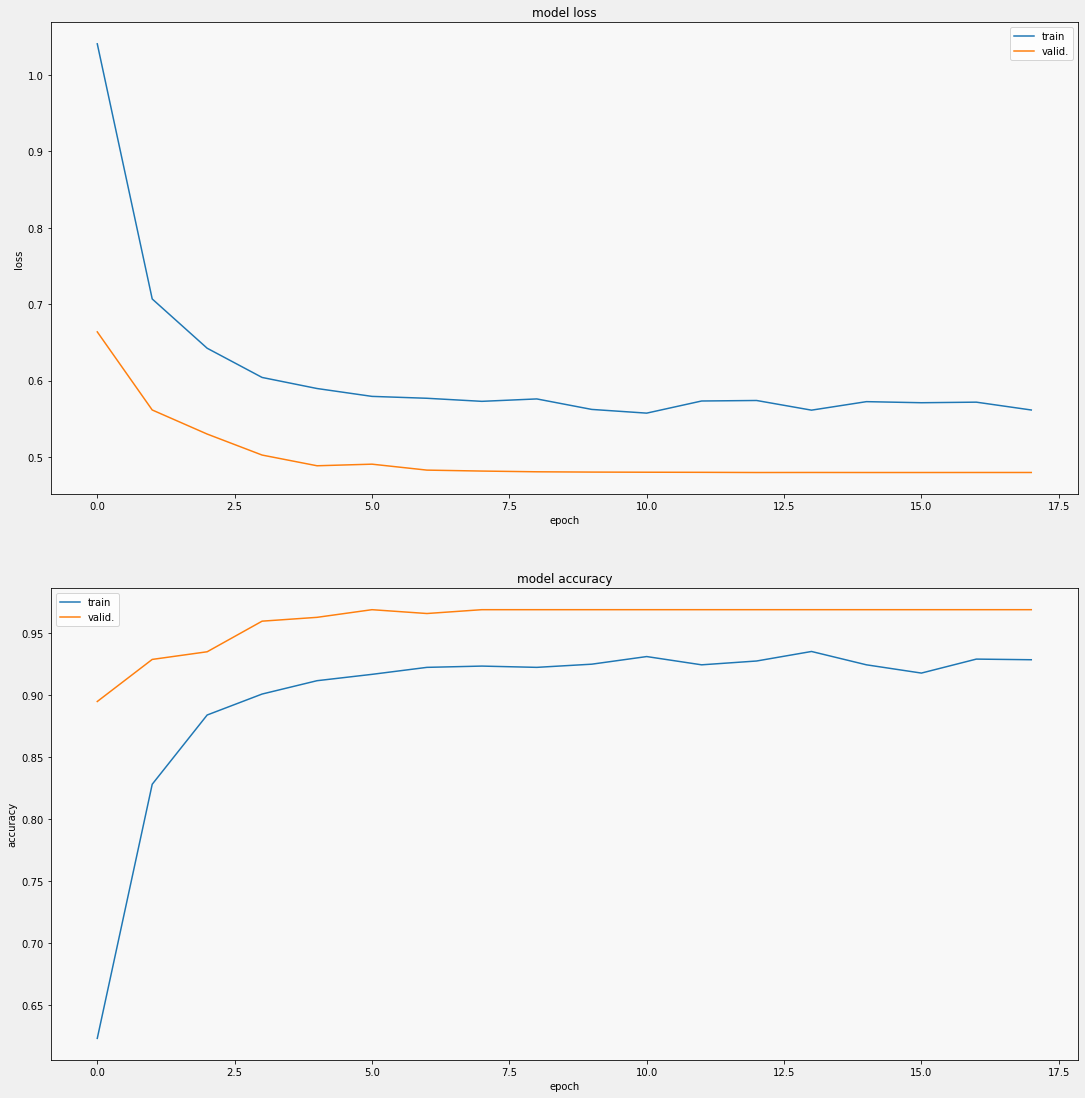

In [34]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

In [35]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

/kaggle/input/diseasecotton/data/test/fresh cotton plant/dsd (405).jpg
/kaggle/input/diseasecotton/data/test/fresh cotton leaf/d (396).jpg
/kaggle/input/diseasecotton/data/test/fresh cotton leaf/d (366).jpg

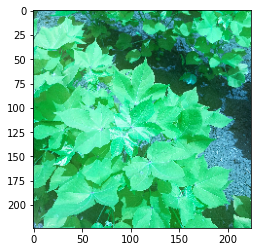

In [36]:
# test image
file_path =  '/kaggle/input/diseasecotton/data/test/fresh cotton plant/dsd (405).jpg'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [37]:
heatmap, top_index = make_gradcam_heatmap(test_image, model_densenet, last_conv_layer_name, classifier_layer_names)
print("predicted as", labels[top_index])

predicted as fresh cotton leaf


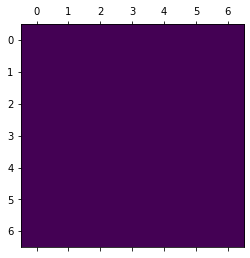

In [38]:
plt.matshow(heatmap)
plt.show()

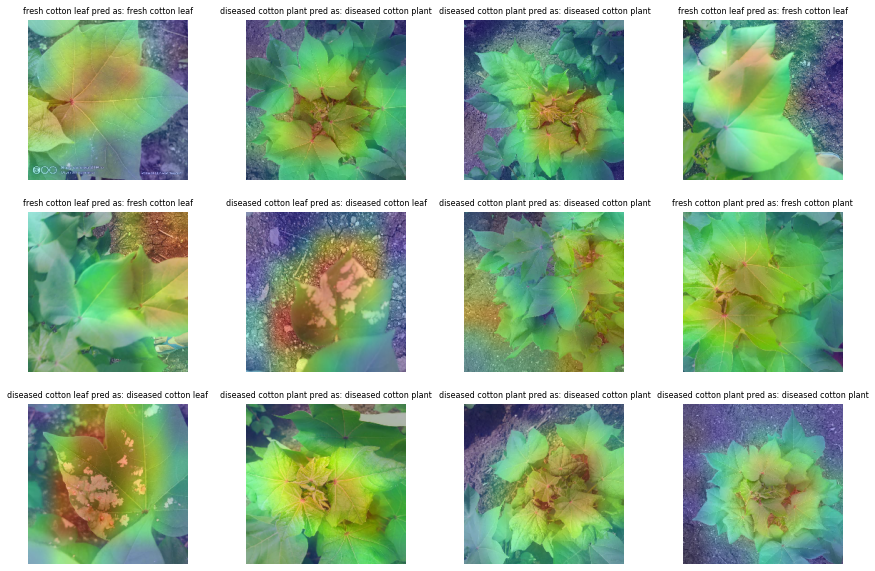

In [39]:
plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_densenet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

Best Model= InceptionV3; Accuracy=97%+.......
Visit this link:https://www.kaggle.com/sohelranaccselab/cotton-disease-classification-part-1?scriptVersionId=43108908